In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# 1 · Load cleaned data
product_df = pd.read_csv("../data/amazon-cleaned.csv")
print(product_df.shape)
print(product_df.isna().sum())

product_df['discount_percent'] = product_df['discounted_price'] / product_df['actual_price']

# 2 · Select numeric features (extend as needed)
num_cols = ["actual_price", "discount_percent", "rating", "rating_count", "encode_review_raing"]
X_train = product_df[num_cols].copy()

X_train.dropna(inplace=True)

X_out = X_train.copy()

(11446, 10)
product_id               0
category                 0
discounted_price         0
actual_price             0
rating                   0
rating_count             2
user_id                  0
review_title           342
review_content         120
encode_review_raing      0
dtype: int64


In [485]:
print(X_train.shape)
print(X_train.duplicated().sum())
X_train.drop_duplicates(inplace=True)
print(X_train.shape)

(11444, 5)
10117
(1327, 5)


In [486]:
# 3 · Scale (important for K‑Means distance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_out_scaled = scaler.transform(X_out)

In [487]:
pca = PCA()
pca.fit(X_train_scaled)

PCA()

/var/folders/sf/zs026qqn0c70ggnkg8smzsqh0000gn/T/ipykernel_71156/793360358.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(principal_components[:,0], principal_components[:,1], cmap='viridis', s=10)
/var/folders/sf/zs026qqn0c70ggnkg8smzsqh0000gn/T/ipykernel_71156/793360358.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = plt.scatter(principal_components[:,0], principal_components[:,2], cmap='viridis', s=10)
/opt/anaconda3/envs/mlds/lib/python3.12/site-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/var/folders/sf/zs026qqn0c70ggnkg8smzsqh0000gn/T/ipykernel_71156/793360358.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(principal_compo

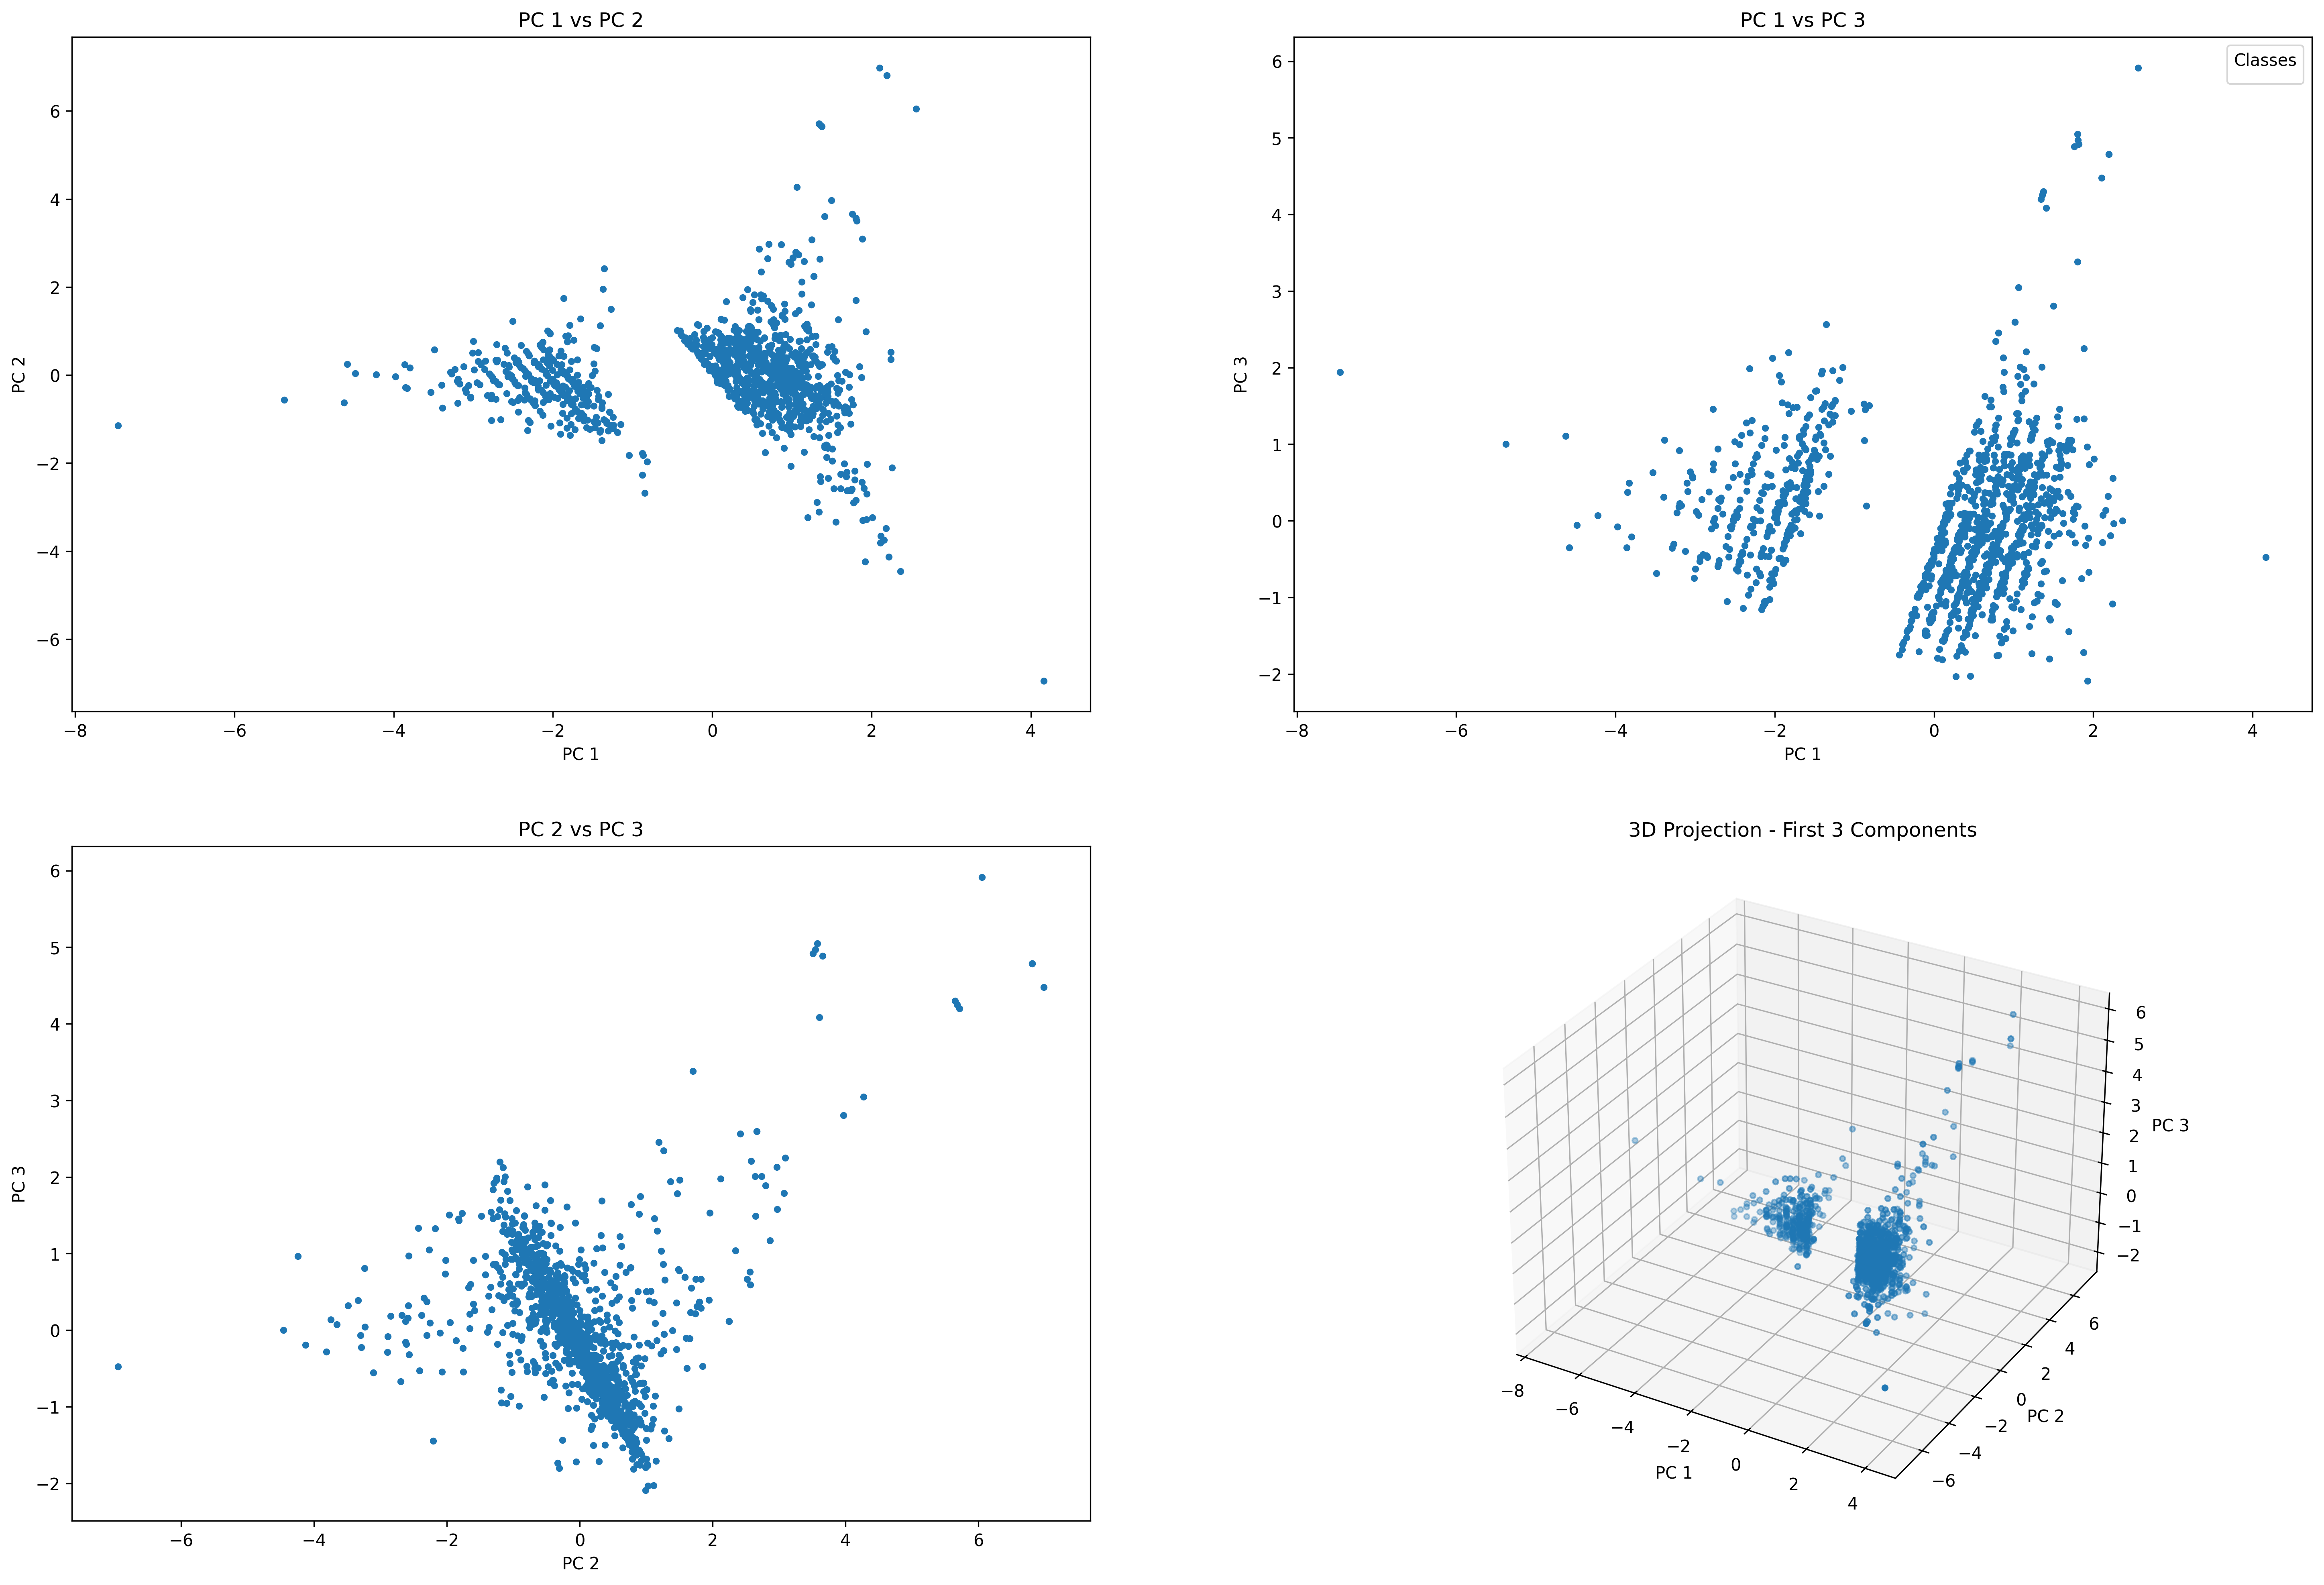

In [488]:
principal_components = pca.transform(X_train_scaled)

plt.figure(figsize=(24,16), dpi = 300)
# PC1 vs PC2
plt.subplot(2,2,1)
plt.scatter(principal_components[:,0], principal_components[:,1], cmap='viridis', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PC 1 vs PC 2')

# PC1 vs PC3
plt.subplot(2,2,2)
scatter2 = plt.scatter(principal_components[:,0], principal_components[:,2], cmap='viridis', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('PC 1 vs PC 3')
plt.legend(*scatter2.legend_elements(), title="Classes")

# PC2 vs PC3
plt.subplot(2,2,3)
plt.scatter(principal_components[:,1], principal_components[:,2], cmap='viridis', s=10)
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('PC 2 vs PC 3')

ax = plt.subplot(2, 2, 4, projection='3d')
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], cmap='viridis', s=10)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D Projection - First 3 Components')

plt.show()

plt.show()

# 4 · Fit K‑Means (k = 6 here, adjust via elbow)
K = 6
kmeans = KMeans(n_clusters=K, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_scaled)

In [489]:
x_train_pca = pca.transform(X_train_scaled)

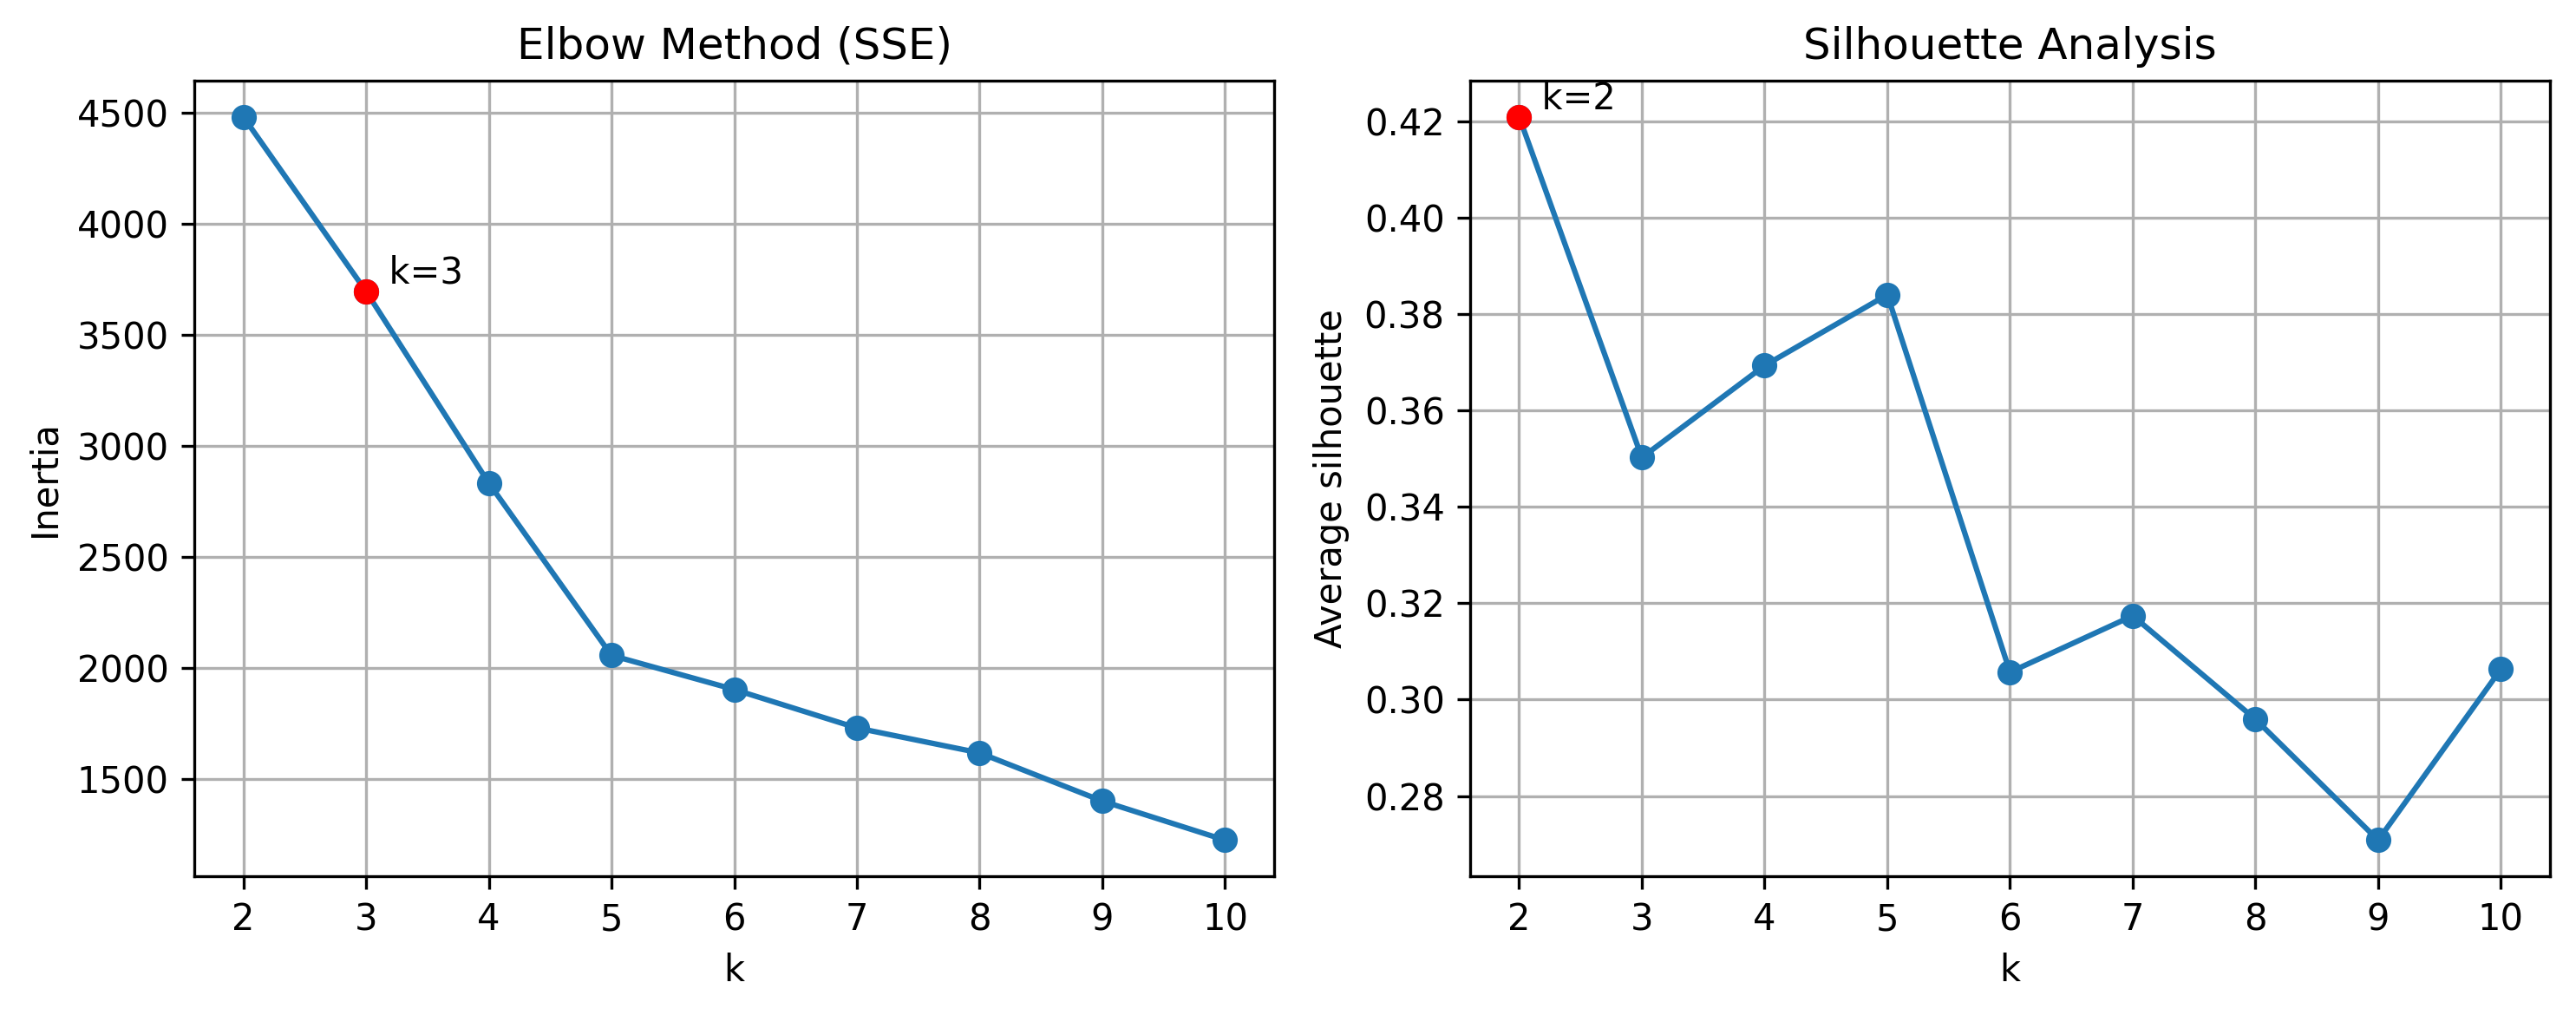

In [490]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- CONFIG ---
k_range = range(2, 11)          # try k = 2 … 10
sample_size = 1256             # subsample for silhouette to save time
random_state = 42

# --- METRIC LOOPS ---
inertias, sil_scores = [], []

for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = km.fit_predict(x_train_pca)
    inertias.append(km.inertia_)
    
    # subsample for silhouette if dataset is huge
    idx = np.random.choice(x_train_pca.shape[0],
                           min(sample_size, x_train_pca.shape[0]),
                           replace=False)
    sil_scores.append(silhouette_score(x_train_pca[idx], labels[idx]))

# --- PLOT ---
plt.figure(figsize=(10, 4), dpi=300)

# Elbow
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker="o")
best_k_elbow = k_range[np.argmax(np.diff(inertias, 2) < 0) + 1]  # crude elbow hint
plt.scatter(best_k_elbow, inertias[best_k_elbow-2], color="red", zorder=3)
plt.text(best_k_elbow, inertias[best_k_elbow-2],
         f"  k={best_k_elbow}", va="bottom", ha="left")
plt.title("Elbow Method (SSE)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker="o")
best_k_sil = k_range[int(np.argmax(sil_scores))]
plt.scatter(best_k_sil, max(sil_scores), color="red", zorder=3)
plt.text(best_k_sil, max(sil_scores),
         f"  k={best_k_sil}", va="bottom", ha="left")
plt.title("Silhouette Analysis")
plt.xlabel("k")
plt.ylabel("Average silhouette")
plt.grid(True)

plt.tight_layout()
plt.show()


In [491]:
final_km = KMeans(n_clusters=5, random_state=random_state)
y_labels = final_km.fit_predict(X_train_scaled)

In [492]:
y_labels

array([0, 0, 1, ..., 1, 2, 2], dtype=int32)

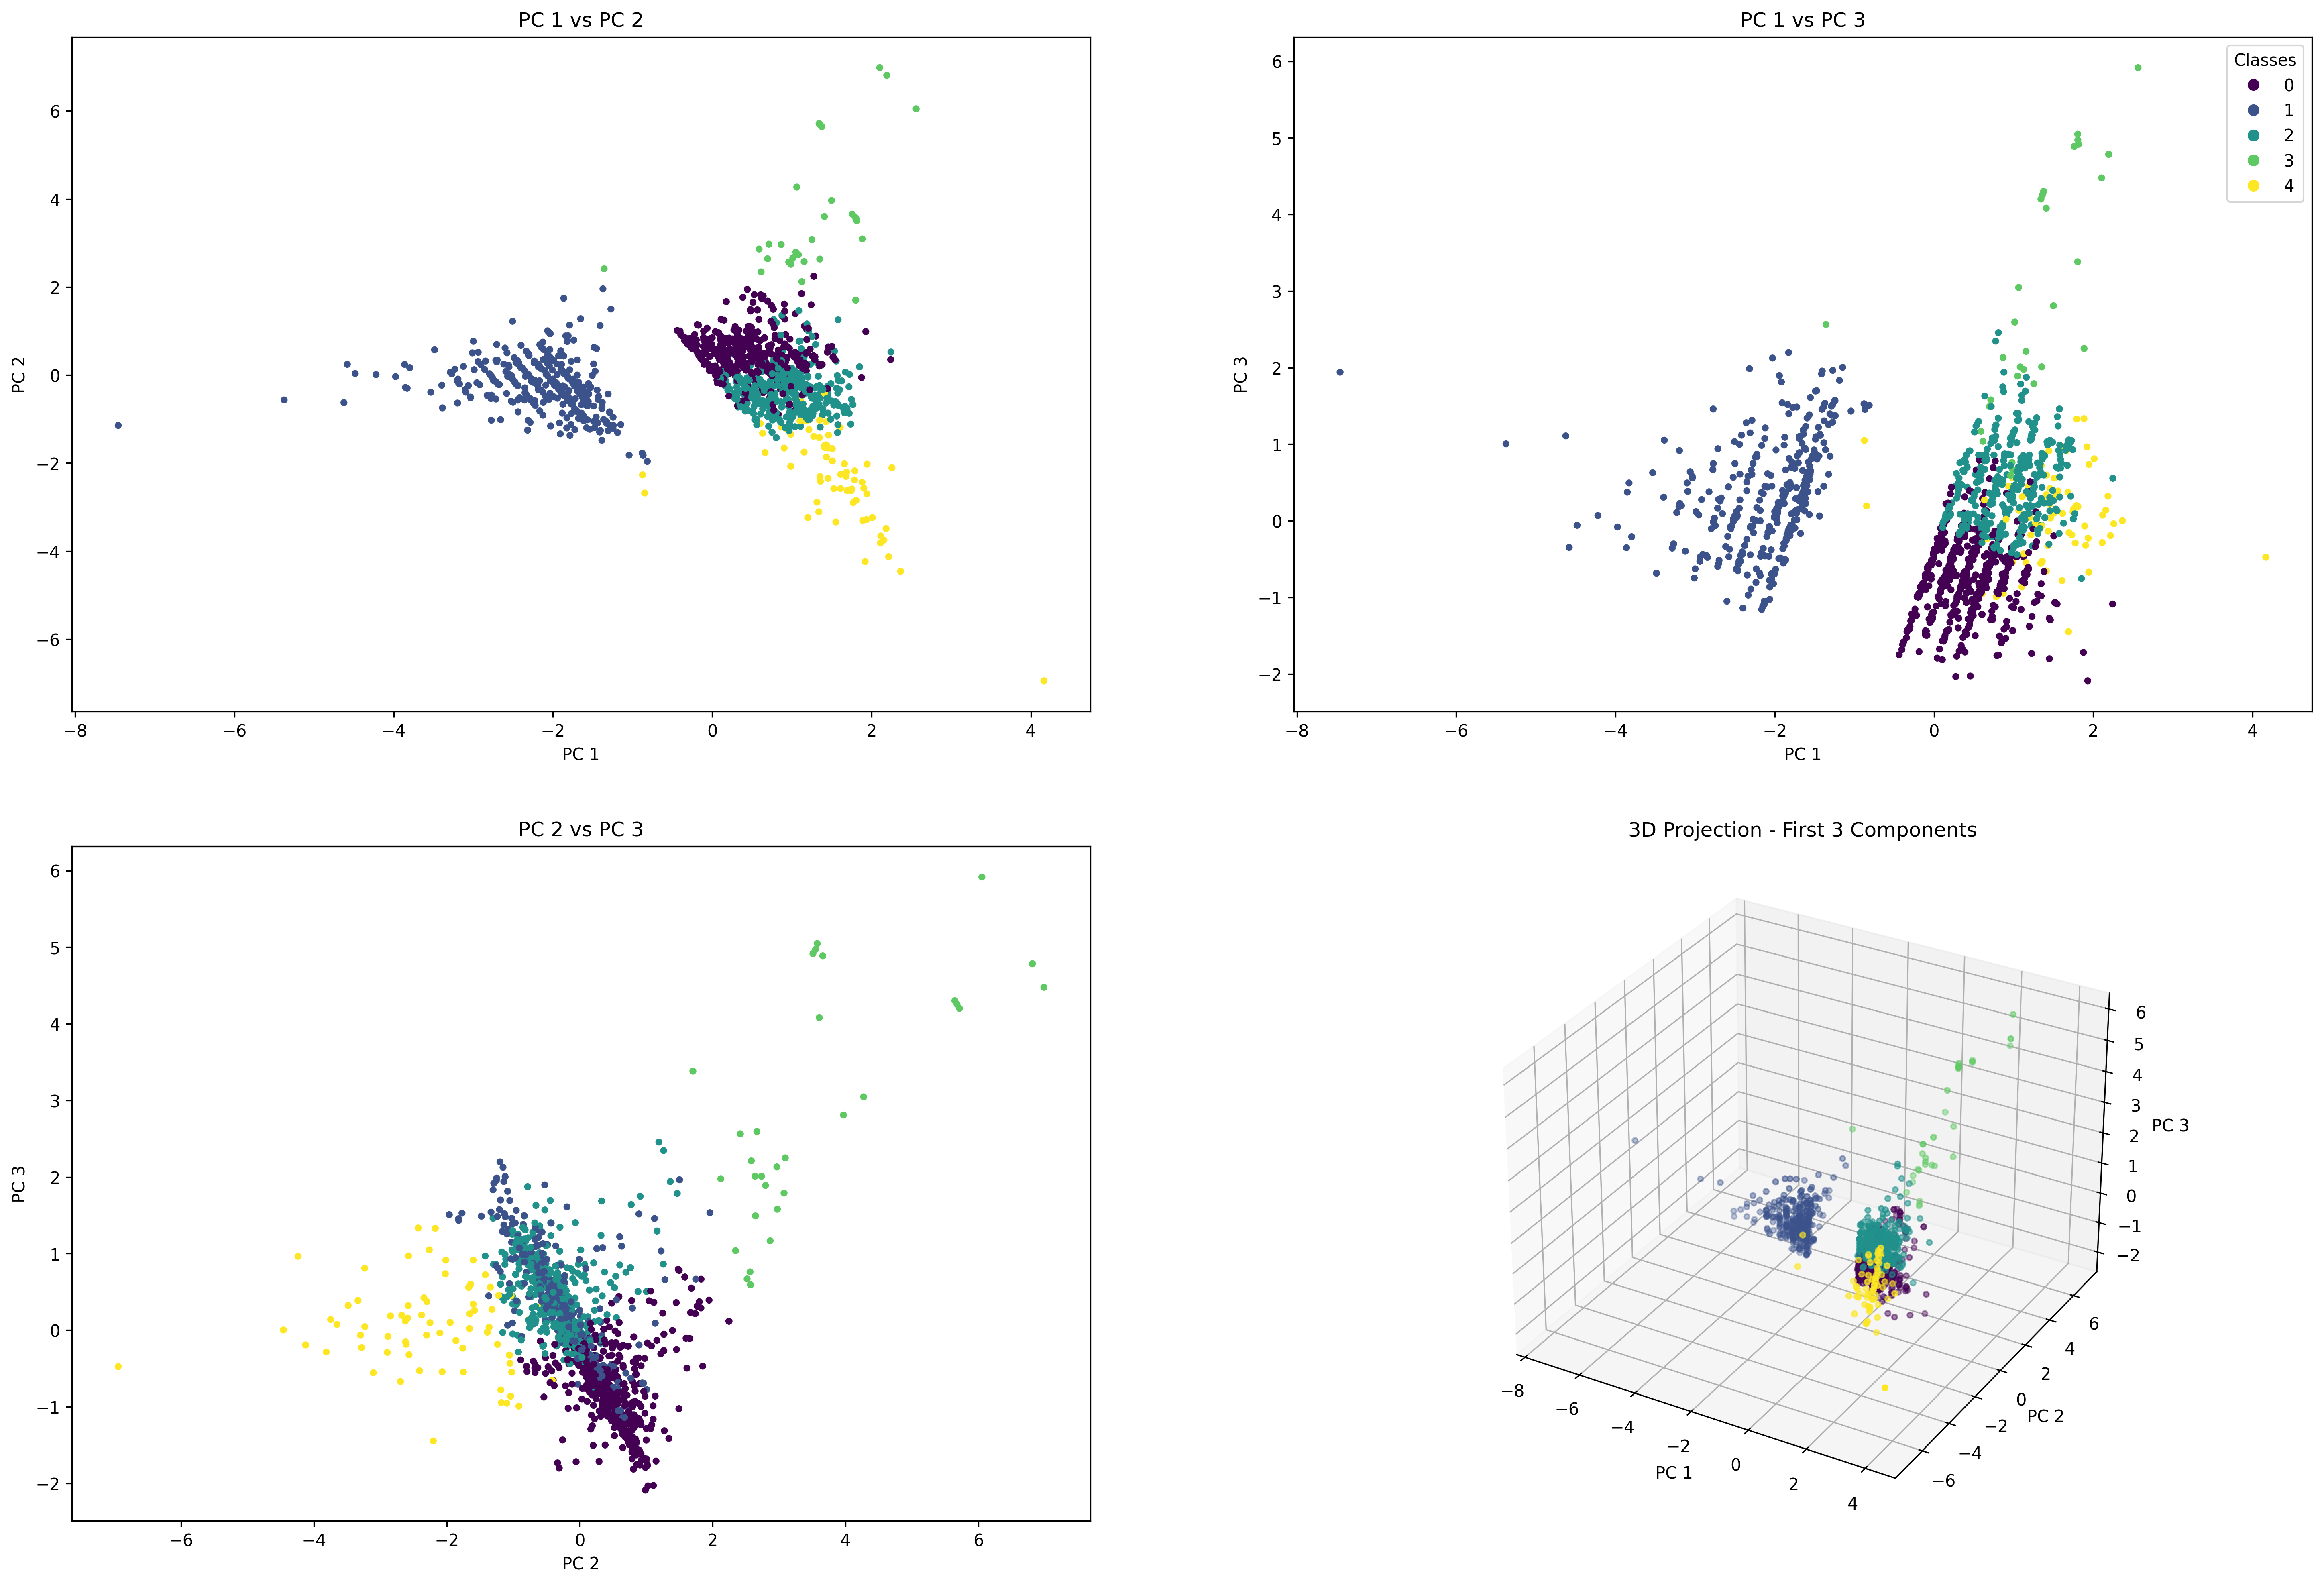

In [493]:
principal_components = pca.transform(X_train_scaled)

plt.figure(figsize=(24,16), dpi = 300)
# PC1 vs PC2
plt.subplot(2,2,1)
plt.scatter(principal_components[:,0], principal_components[:,1], c = y_labels, cmap='viridis', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PC 1 vs PC 2')

# PC1 vs PC3
plt.subplot(2,2,2)
scatter2 = plt.scatter(principal_components[:,0], principal_components[:,2], c = y_labels, cmap='viridis', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('PC 1 vs PC 3')
plt.legend(*scatter2.legend_elements(), title="Classes")

# PC2 vs PC3
plt.subplot(2,2,3)
plt.scatter(principal_components[:,1], principal_components[:,2], c = y_labels, cmap='viridis', s=10)
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('PC 2 vs PC 3')

ax = plt.subplot(2, 2, 4, projection='3d')
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c = y_labels, cmap='viridis', s=10)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D Projection - First 3 Components')

plt.show()

plt.show()

In [494]:

n_clusters = 5
kmeans_on_scaled = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans_on_scaled.fit_predict(X_train_scaled)

In [495]:

X_train_with_clusters = X_train.copy()
X_train_with_clusters['cluster'] = cluster_labels

print(f"\nK-Means clustering performed on X_train_scaled with {n_clusters} clusters.")
print(f"Number of data points in each cluster:\n{X_train_with_clusters['cluster'].value_counts().sort_index()}")


K-Means clustering performed on X_train_scaled with 5 clusters.
Number of data points in each cluster:
cluster
0    516
1    334
2    373
3     33
4     71
Name: count, dtype: int64


In [496]:

cluster_analysis = X_train_with_clusters.groupby('cluster')[num_cols].agg(['mean', 'median', 'std', 'min', 'max'])

for col in num_cols:
    print(f"\nFeature: {col}")
    print(cluster_analysis[col])

cluster_means = X_train_with_clusters.groupby('cluster')[num_cols].mean()
print(cluster_means)


Feature: actual_price
                 mean   median           std      min       max
cluster                                                        
0         3098.501938   1499.0   4156.907492    175.0   24999.0
1         3044.803234   1724.5   4012.938707     39.0   28999.0
2         3800.163539   1699.0   5209.772373     50.0   22900.0
3         2557.545455   1400.0   2726.210810    475.0   10999.0
4        44233.070423  39990.0  19822.316595  22990.0  139900.0

Feature: discount_percent
             mean    median       std       min       max
cluster                                                  
0        0.385191  0.398798  0.113506  0.058812  0.576597
1        0.480097  0.476337  0.206139  0.099099  1.000000
2        0.756783  0.744402  0.132147  0.559118  1.000000
3        0.489451  0.444615  0.181951  0.220714  0.931787
4        0.626136  0.628465  0.144831  0.240401  1.000000

Feature: rating
             mean  median       std  min  max
cluster                          

In [497]:
if len(np.unique(cluster_labels)) > 1:
    silhouette = silhouette_score(X_train_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_train_scaled, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_train_scaled, cluster_labels)

    print(f"Silhouette Score (on X_train_scaled): {silhouette:.3f}")
    print(f"Davies-Bouldin Index (on X_train_scaled): {davies_bouldin:.3f}")
    print(f"Calinski-Harabasz Index (on X_train_scaled): {calinski_harabasz:.3f}")
else:
    print("Model evaluation metrics require more than 1 cluster label.")

Silhouette Score (on X_train_scaled): 0.384
Davies-Bouldin Index (on X_train_scaled): 0.842
Calinski-Harabasz Index (on X_train_scaled): 735.991


In [498]:

print("\n--- Cluster Profiles (Based on Mean Values of Original Features) ---")

global_means = X_train[num_cols].mean()
print("\nGlobal Mean Values for Features:")
print(global_means)
print("\nCluster Mean Values for Features (from X_train_with_clusters):")
print(cluster_means)




--- Cluster Profiles (Based on Mean Values of Original Features) ---

Global Mean Values for Features:
actual_price            5469.630203
discount_percent           0.529012
rating                     4.092992
rating_count           18260.710625
encode_review_raing        1.745290
dtype: float64

Cluster Mean Values for Features (from X_train_with_clusters):
         actual_price  discount_percent    rating   rating_count  \
cluster                                                            
0         3098.501938          0.385191  4.209690   13799.777132   
1         3044.803234          0.480097  3.703593    8559.437126   
2         3800.163539          0.756783  4.241823   14282.313673   
3         2557.545455          0.489451  4.193939  246115.090909   
4        44233.070423          0.626136  4.247887   11314.436620   

         encode_review_raing  
cluster                       
0                   2.000000  
1                   0.997006  
2                   2.000000  
3    

## Analyse
- Cluster 0: Low discount, Midrange price, High rating and Lower than avg rating count
- Affordable product that is well rated, high rating count despite having low discount -> might show sign of brand loyalty or brand quality

- Cluster 1: Mid price, Normal discount, lowwww rating and also low rating count
- The least frequent bought items, high discount but low rating may show sign of poor quality or bad customer service

- Cluster 2: Mid price, verry high discount, good rating and normal rating count
- The high discount percent maybe the reason lead to high raing

- Cluster 3: Low price, normal discount, high raing and Very high raing count
- Very frequently bought - cheap item. 

- Cluster 4: High price, high discount, high raing and lower than average rating count
- Luxury brand with sufficient discount



In [499]:
out_cluster_labels = kmeans_on_scaled.fit_predict(X_out_scaled)
print(len(out_cluster_labels))
print(len(product_df))
out_product_df = product_df[['product_id','user_id','rating_count']].copy()
print(out_product_df.isna().sum())
out_product_df.dropna(inplace=True)
out_product_df['kmeans_cluster'] = out_cluster_labels

11444
11446
product_id      0
user_id         0
rating_count    2
dtype: int64


In [500]:
out_product_df

,product_id,user_id,rating_count,kmeans_cluster
0,B07JW9H4J1,7918,24269.0,0
1,B07JW9H4J1,7878,24269.0,0
2,B07JW9H4J1,3737,24269.0,0
3,B07JW9H4J1,867,24269.0,0
4,B07JW9H4J1,285,24269.0,0
...,...,...,...,...
11441,B01486F4G6,3011,6987.0,3
11442,B01486F4G6,7396,6987.0,3
11443,B01486F4G6,8554,6987.0,3
11444,B01486F4G6,4822,6987.0,3


In [ ]:
out_product_df.to_csv('../data/amazon-kmeans-clusters.csv', index=False)